In [84]:
import pandas as pd
import numpy as np
import torch
import pickle
import tensorflow_hub as hub
embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4")

# Read Price Data

In [12]:
import os

# Define the directory path
directory = 'stocknet-code/data/price/preprocessed/'

# Initialize an empty list to store the dataframes
price_df = []

# Iterate over the files in the directory
for filename in os.listdir(directory):
    # Read the file into a dataframe
    df = pd.read_csv(os.path.join(directory, filename), sep='\t', header=None, names=['date', 'movement percent', 'open price', 'high price', 'low price', 'close price', 'volume'])
    # Add a new column for the stock ticker
    df['stock'] = filename.split('.')[0]
    # Append the dataframe to the list
    price_df.append(df)

# Concatenate all the dataframes into a single one
price_df = pd.concat(price_df, ignore_index=True).loc[:,['stock', 'date', 'movement percent', 'open price', 'high price', 'low price', 'close price', 'volume']]


In [16]:
price_df.dtypes

stock                object
date                 object
movement percent    float64
open price          float64
high price          float64
low price           float64
close price         float64
volume              float64
dtype: object

In [17]:
price_df.stock.value_counts()

stock
BHP     1257
NVS     1257
CODI    1257
MRK     1257
D       1257
        ... 
SNP     1256
ABBV    1176
BABA     744
AGFS     700
GMRE     296
Name: count, Length: 88, dtype: int64

In [20]:
# date ranges:
# training: 01/01/2014 to 31/07/2015 
# validation: 01/08/2015 to 30/09/2015 
# testing: 01/10/2015 to 01/01/2016 

price_train_df = price_df[(price_df['date'] >= '2014-01-01') & (price_df['date'] <= '2015-07-31')]
price_val_df = price_df[(price_df['date'] >= '2015-08-01') & (price_df['date'] <= '2015-09-30')]
price_test_df = price_df[(price_df['date'] >= '2015-10-01') & (price_df['date'] <= '2016-01-01')]

price_train_df.shape, price_test_df.shape


((34220, 8), (5568, 8))

In [32]:
# Count the occurrences of each stock in the training dataset
train_stock_valcount = price_train_df.stock.value_counts()
# Final stock list for train and test: Filter the stocks that have the maximum occurrences and convert the index to a list
filtered_stock_list = train_stock_valcount[train_stock_valcount >= train_stock_valcount.max()].index.tolist()


# Read Graph Data

Make sure all stocks in filtered_stock_list also exists in graph data

In [132]:
# Pandas read CSV NYSE_wiki.csv and NASDAQ_wiki.csv, both are without headers
# Add headers ["stock", "id"]
nyse = pd.read_csv("Temporal_Relational_Stock_Ranking/data/relation/wikidata/NYSE_wiki.csv", header=None)
nyse.columns = ["stock", "id"]
nasdaq = pd.read_csv("Temporal_Relational_Stock_Ranking/data/relation/wikidata/NASDAQ_wiki.csv", header=None)
nasdaq.columns = ["stock", "id"]

# Combine NYSE and NASDAQ dataframes
stocknet_graph_df = pd.concat([nyse, nasdaq], ignore_index=True)

# Remove stocks from stocknet_graph_df where id is 'unknown'
stocknet_graph_df = stocknet_graph_df[stocknet_graph_df['id'] != 'unknown']


In [133]:
# Find missing stocks
missing_stocks = [stock for stock in filtered_stock_list if stock not in stocknet_graph_df['stock'].values]

# Print missing stocks if any
if missing_stocks:
    print("Missing stocks in graph data:", missing_stocks)

# Create a list of stocks that are in both lists
common_stocks = [stock for stock in filtered_stock_list if stock in stocknet_graph_df['stock'].values]
len(common_stocks)


Missing stocks in graph data: ['BHP', 'BCH', 'CODI', 'UL', 'MDT', 'SPLP', 'RDS-B', 'SO', 'NEE', 'UNH', 'BSAC', 'SRE', 'PICO', 'DUK', 'CHTR', 'BRK-A', 'REX']


68

# Filter Train, Test, and Val Stocks

In [135]:
# Filter the dataframes to only include stocks in common_stocks
price_train_df = price_train_df[price_train_df['stock'].isin(common_stocks)]
price_val_df = price_val_df[price_val_df['stock'].isin(common_stocks)]
price_test_df = price_test_df[price_test_df['stock'].isin(common_stocks)]

price_train_df.shape, price_val_df.shape, price_test_df.shape

((27064, 8), (2856, 8), (4352, 8))

In [136]:
# Sanity check if all column stock in price_train_df has the same set of values of column date
unique_dates = price_train_df['date'].unique()
for stock in price_train_df['stock'].unique():
    stock_dates = price_train_df[price_train_df['stock'] == stock]['date'].unique()
    if not np.array_equal(unique_dates, stock_dates):
        print(f"Stock {stock} does not have the same set of dates as the rest.")

# Result: no out = all stocks have the same set of dates

# Read Tweets Data

In [137]:
# Read all files in stocknet-code/tweet/preprocessed/ and store them into a DataFrame

import os
import pandas as pd
import json

# Initialize an empty list to store the data
data = []

# Path to the stock directories
base_path = 'stocknet-code/data/tweet/preprocessed/'

# Iterate through each stock directory
for stock_ticker in os.listdir(base_path):
    stock_path = os.path.join(base_path, stock_ticker)
    
    # Check if it's a directory
    if os.path.isdir(stock_path):
        # Iterate through each date file in the stock directory
        for date_file in os.listdir(stock_path):
            date_path = os.path.join(stock_path, date_file)
            
            # Check if it's a file
            if os.path.isfile(date_path):
                tweets = []
                
                # Read the file and collect tweets
                with open(date_path, 'r') as f:
                    for line in f:
                        tweet_data = json.loads(line.strip())
                        tweets.append(tweet_data['text'])  # Assuming 'text' is the key for tweet content
                
                # Append the stock ticker, date, and list of tweets to the data list
                data.append({
                    'stock': stock_ticker,
                    'date': date_file,
                    'tweets': tweets
                })

# Create a DataFrame from the collected data
tweets_df = pd.DataFrame(data)

tweets_df


,stock,date,tweets
0,VZ,2014-10-14,"[[$, gdp, news, :, "", actives, on, open, AT_US..."
1,VZ,2015-06-20,"[[rt, AT_USER, psw, /, seeking, alpha, june, t..."
2,VZ,2015-02-10,"[[weekly, s, &, p100, stocks, performance, $, ..."
3,VZ,2015-05-07,"[[tip, 4, how, to, identify, a, hot, sector, ?..."
4,VZ,2014-08-20,"[[overpriced, ?, if, you, have, a, superior, p..."
...,...,...,...
25706,CODI,2014-09-07,"[[stock, contest, !, !, pick, $, googl, and, w..."
25707,CODI,2015-05-18,"[[codi, compass, diversified, holdings, 52wk, ..."
25708,CODI,2014-08-09,"[[$, codi, compass, diversified, holdings, fil..."
25709,CODI,2015-06-01,"[[codi, compass, diversified, holdings, financ..."


In [138]:
# Filter tweets_df

tweets_df = tweets_df[tweets_df.stock.isin(common_stocks)]
print(tweets_df.shape)

# Convert 'date' column to datetime format
tweets_df['date'] = pd.to_datetime(tweets_df['date'])

# Define date ranges for training, validation, and testing
training_start = '2014-01-01'
training_end = '2015-07-31'
validation_start = '2015-08-01'
validation_end = '2015-09-30'
testing_start = '2015-10-01'
testing_end = '2016-01-01'

# Filter tweets for each date range
tweets_train_df = tweets_df[(tweets_df['date'] >= training_start) & (tweets_df['date'] <= training_end)]
tweets_val_df = tweets_df[(tweets_df['date'] >= validation_start) & (tweets_df['date'] <= validation_end)]
tweets_test_df = tweets_df[(tweets_df['date'] >= testing_start) & (tweets_df['date'] <= testing_end)]

# Display the shape of each dataset
print("Training Tweets Shape:", tweets_train_df.shape)
print("Validation Tweets Shape:", tweets_val_df.shape)
print("Testing Tweets Shape:", tweets_test_df.shape)


(23438, 3)
Training Tweets Shape: (18324, 3)
Validation Tweets Shape: (2008, 3)
Testing Tweets Shape: (3106, 3)


/var/folders/4z/mfq1y5w57hj01ttff7smkspw0000gn/T/ipykernel_2798/664297115.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['date'] = pd.to_datetime(tweets_df['date'])


# Generate Time Windows for Train, Val, Test

In [139]:

import pandas as pd

def generate_time_windows(df, window_size=5):
    # Extract the dates from the DataFrame
    dates = sorted(set(df['date'].tolist()))
    
    # Generate time windows
    windows = [dates[i:i + window_size] for i in range(len(dates) - window_size + 1)]
    
    return windows

# Assuming price_train_df, price_val_df, and price_test_df are already defined
train_windows = generate_time_windows(price_train_df)
val_windows = generate_time_windows(price_val_df)
test_windows = generate_time_windows(price_test_df)

# Display the results
print("Train Windows:", train_windows[:5])
print("Validation Windows:", val_windows[:5])
print("Test Windows:", test_windows[:5])


Train Windows: [['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08'], ['2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09'], ['2014-01-06', '2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10'], ['2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13'], ['2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13', '2014-01-14']]
Validation Windows: [['2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06', '2015-08-07'], ['2015-08-04', '2015-08-05', '2015-08-06', '2015-08-07', '2015-08-10'], ['2015-08-05', '2015-08-06', '2015-08-07', '2015-08-10', '2015-08-11'], ['2015-08-06', '2015-08-07', '2015-08-10', '2015-08-11', '2015-08-12'], ['2015-08-07', '2015-08-10', '2015-08-11', '2015-08-12', '2015-08-13']]
Test Windows: [['2015-10-01', '2015-10-02', '2015-10-05', '2015-10-06', '2015-10-07'], ['2015-10-02', '2015-10-05', '2015-10-06', '2015-10-07', '2015-10-08'], ['2015-10-05', '2015-10-06', '2015-10-07', '2015-10-08', '2015-10-09'], ['2015-10-06

# Fetch Price Time Windows, Convert to Numpy

In [140]:
import numpy as np

def fetch_price_data(price_df, train_windows, common_stocks):
    num_stocks = len(common_stocks)
    num_windows = len(train_windows)
    window_size = 5
    feature_size = 3  # close, high, low

    # Initialize the NumPy array to hold the data
    price_data_array = np.empty((num_windows, num_stocks, window_size, feature_size), dtype=float)

    # Create a mapping of stock to its index based on common_stocks
    stock_index = {stock: idx for idx, stock in enumerate(common_stocks)}

    # Iterate through each window
    for window_idx, window in enumerate(train_windows):
        for date in window:
            # Fetch the rows corresponding to the date
            rows = price_df[price_df['date'] == date]
            for _, row in rows.iterrows():
                stock = row['stock']
                if stock in stock_index:
                    stock_idx = stock_index[stock]
                    # Store the close, high, low prices in the array
                    price_data_array[window_idx, stock_idx, :, 0] = row['close price']
                    price_data_array[window_idx, stock_idx, :, 1] = row['high price']
                    price_data_array[window_idx, stock_idx, :, 2] = row['low price']

    return price_data_array

# Assuming common_stocks is defined
# Fetch the price data based on the train windows
price_train_np = fetch_price_data(price_train_df, train_windows, common_stocks)
price_val_np = fetch_price_data(price_val_df, val_windows, common_stocks)
price_test_np = fetch_price_data(price_test_df, test_windows, common_stocks)

# Display the shape of the resulting array
print("price_train_np", price_train_np.shape)
print("price_val_np", price_val_np.shape)
print("price_test_np", price_test_np.shape)

price_train_np (394, 68, 5, 3)
price_val_np (38, 68, 5, 3)
price_test_np (60, 68, 5, 3)


# Save Train, Val, Test: **Price**

In [141]:
for i in range(price_train_np.shape[0]):
    np.save(f'improv_data/train_price/{str(i).zfill(10)}.npy', price_train_np[i, :, :, :])


In [142]:
# Initialize the dictionary to store the data
val_dict = {}
# Change 'price_train_np' to 'price_val_np' or 'price_test_np' as needed
for i in range(price_val_np.shape[0]):  # Change to price_test_np for test data
    val_dict[str(i).zfill(10)] = price_val_np[i, :, :]  # Change to price_test_np for test data

test_dict = {}
# Change 'price_train_np' to 'price_val_np' or 'price_test_np' as needed
for i in range(price_test_np.shape[0]):  # Change to price_test_np for test data
    test_dict[str(i).zfill(10)] = price_test_np[i, :, :]  # Change to price_test_np for test data

# Save validation data dictionary
with open('improv_data/val_price_feature_data.p', 'wb') as fp:
    pickle.dump(val_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Save test data dictionary  
with open('improv_data/price_feature_data.p', 'wb') as fp:
    pickle.dump(test_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Now data_dict contains all the data indexed by the formatted string keys

# Fetch Train, Val, Test: **Labels**

The training data we generated: time window of 5 days, [t-T, t-1]
So the label we need is on day t

ex: window = [1,2,3,4,5]
label = [6]

In [143]:
# Fetch days we need to generate labels for

# Fetch unique dates in price_df
# Then sort them
unique_dates = sorted(price_df['date'].unique())

In [145]:
# For each element in window, fetch last element, then fetch unique_windows[arg(date) + 1] 
def generate_labels(windows, unique_dates, price_df, common_stocks):
    """
    Generate labels for price movement prediction.
    
    Args:
        windows: List of date windows
        unique_dates: Sorted list of unique dates
        price_df: DataFrame containing price data
        common_stocks: List of stock symbols
        
    Returns:
        numpy array of shape (n_windows, n_stocks, 2) containing binary labels
    """
    label_dates = []
    for window in windows:
        d_min_1 = window[-1]
        label_date = unique_dates[unique_dates.index(d_min_1) + 1]
        label_dates.append(label_date)

    # For each label_date, For each stock, fetch the close price and the close price of the previous day
    labels_np = np.empty((len(label_dates), len(common_stocks), 2), dtype=float)

    for label_idx, label_date in enumerate(label_dates):
        for stock_idx, stock in enumerate(common_stocks):
            close_price = price_df[(price_df['date'] == label_date) & (price_df['stock'] == stock)]['close price'].values[0]
            close_price_prev_day = price_df[(price_df['date'] == unique_dates[unique_dates.index(label_date) - 1]) & (price_df['stock'] == stock)]['close price'].values[0]
            
            labels_np[label_idx, stock_idx, 0] = close_price >= close_price_prev_day
            labels_np[label_idx, stock_idx, 1] = close_price < close_price_prev_day

    return labels_np

# Generate labels for train data
labels_train_np = generate_labels(train_windows, unique_dates, price_df, common_stocks)
# Generate labels for val and test data
labels_val_np = generate_labels(val_windows, unique_dates, price_df, common_stocks)
labels_test_np = generate_labels(test_windows, unique_dates, price_df, common_stocks)

labels_train_np.shape, labels_val_np.shape, labels_test_np.shape

((394, 68, 2), (38, 68, 2), (60, 68, 2))

In [146]:
# Save labels_train_np into improv_data/train_label 

for i in range(labels_train_np.shape[0]):
    np.save(f'improv_data/train_label/{str(i).zfill(10)}.npy', labels_train_np[i, :, :])

In [147]:
# Initialize the dictionary to store the data
val_dict = {}
# Change 'price_train_np' to 'price_val_np' or 'price_test_np' as needed
for i in range(labels_val_np.shape[0]):  # Change to price_test_np for test data
    val_dict[str(i).zfill(10)] = labels_val_np[i, :, :]  # Change to price_test_np for test data

test_dict = {}
# Change 'price_train_np' to 'price_val_np' or 'price_test_np' as needed
for i in range(labels_test_np.shape[0]):  # Change to labels_test_np for test data
    test_dict[str(i).zfill(10)] = labels_test_np[i, :, :]  # Change to price_test_np for test data

# Save validation data dictionary
with open('improv_data/val_label_data.p', 'wb') as fp:
    pickle.dump(val_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Save test data dictionary  
with open('improv_data/label_data.p', 'wb') as fp:
    pickle.dump(test_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Generate Tweet Data

In [148]:
def process_tweets(windows, tweets_df, common_stocks, max_tweets=30, n_window=5, emb_size=512):
    """
    Process tweets for given windows and stocks into embedded vectors
    
    Args:
        windows: List of date windows
        tweets_df: DataFrame containing tweets
        common_stocks: List of stock symbols
        max_tweets: Maximum tweets per day
        n_window: Number of days per window
        emb_size: Size of tweet embeddings
        
    Returns:
        numpy array of shape (n_windows, n_stocks, days_per_window, n_tweets_per_day, emb_size)
    """
    all_tweets = []
    
    for window in windows:
        stock_tweets = []
        for stock in common_stocks:
            window_tweets = []
            for date in window:
                filtered_tweets = tweets_df[(tweets_df['stock'] == stock) & (tweets_df['date'] == date)]['tweets'].values
                tweets = filtered_tweets[0] if len(filtered_tweets) > 0 else []
                # tweets is a list of list of strings. ex [['hello', 'world'], ['hi', 'moon']]. each element represents a splitted tweet
                # Embed each tweet
                day_tweets = []
                for tweet in tweets:
                    tweet_text = ' '.join([w for w in tweet if w])
                    tweet_vec = embed([tweet_text])[0].numpy()
                    day_tweets.append(tweet_vec)
                # Pad the tweets with padding nparray if the number of tweets is less than max_tweets
                # Pad or truncate tweets for this day
                if len(day_tweets) > 0:
                    day_tweets = np.array(day_tweets[:max_tweets])
                    if len(day_tweets) < max_tweets:
                        padding_needed = max_tweets - len(day_tweets)
                        padding_array = np.zeros((padding_needed, emb_size))
                        day_tweets = np.vstack([day_tweets, padding_array])
                else:
                    day_tweets = np.zeros((max_tweets, emb_size))
                # Append the tweets to the window_tweets
                window_tweets.append(day_tweets)
            if len(window_tweets) < n_window:
                padding_needed = n_window - len(window_tweets)
                padding_array = np.zeros((padding_needed, max_tweets, emb_size))
                window_tweets = np.vstack([window_tweets, padding_array])
            stock_tweets.append(window_tweets)
        all_tweets.append(stock_tweets)

    return np.array(all_tweets)

# Process train/val/test data
all_tweets_train = process_tweets(train_windows, tweets_train_df, common_stocks)
all_tweets_val = process_tweets(val_windows, tweets_val_df, common_stocks) 
all_tweets_test = process_tweets(test_windows, tweets_test_df, common_stocks)

print("Train tweets shape:", all_tweets_train.shape)
print("Val tweets shape:", all_tweets_val.shape) 
print("Test tweets shape:", all_tweets_test.shape)

Train tweets shape: (394, 68, 5, 30, 512)
Val tweets shape: (38, 68, 5, 30, 512)
Test tweets shape: (60, 68, 5, 30, 512)


In [149]:
# Save train tweets

for i in range(all_tweets_train.shape[0]):
    np.save(f'improv_data/train_text/{str(i).zfill(10)}.npy', all_tweets_train[i, :, :, :])

In [150]:
# Initialize the dictionary to store the data
val_dict = {}
for i in range(all_tweets_val.shape[0]):
    val_dict[str(i).zfill(10)] = all_tweets_val[i, :, :, :]

test_dict = {}
for i in range(all_tweets_test.shape[0]):
    test_dict[str(i).zfill(10)] = all_tweets_test[i, :, :, :]

# Save validation data dictionary
with open('improv_data/val_text_feature_data.p', 'wb') as fp:
    pickle.dump(val_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Save test data dictionary  
with open('improv_data/text_feature_data.p', 'wb') as fp:
    pickle.dump(test_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

# Make Graph

In [171]:
# Filter stocknet_graph_df to only include stocks in common_stocks
stocknet_graph_df = stocknet_graph_df[stocknet_graph_df['stock'].isin(common_stocks)]
stocknet_graph_df.to_csv('improv_data/StockNet_wiki.csv', index=False, header=False)

with open("Temporal_Relational_Stock_Ranking/data/relation/wikidata/NASDAQ_connections.json", "r") as f:
    nasdaq_connections = json.load(f)

with open("Temporal_Relational_Stock_Ranking/data/relation/wikidata/NYSE_connections.json", "r") as f:
    nyse_connections = json.load(f)


In [172]:
# Get list of valid IDs from stocknet
valid_ids = set(stocknet_graph_df['id'].values)

# Filter nasdaq_connections
cleaned_nasdaq_connections = {k: {k2: v2 for k2, v2 in v.items() if k2 in valid_ids} 
                            for k, v in nasdaq_connections.items() 
                            if k in valid_ids}

# Filter nyse_connections 
cleaned_nyse_connections = {k: {k2: v2 for k2, v2 in v.items() if k2 in valid_ids}
                          for k, v in nyse_connections.items()
                          if k in valid_ids}

# Missing connections
missing_connections = set(valid_ids) - set(cleaned_nasdaq_connections.keys()) - set(cleaned_nyse_connections.keys())

# Remove any empty dictionaries
cleaned_nasdaq_connections = {k: v for k, v in cleaned_nasdaq_connections.items() if v}
cleaned_nyse_connections = {k: v for k, v in cleaned_nyse_connections.items() if v}


In [173]:
with open("improv_data/StockNet_connections.json", "w") as f:
    # Combine the two dictionaries
    combined_connections = {**cleaned_nasdaq_connections, **cleaned_nyse_connections}
    json.dump(combined_connections, f)
    
# Sanity check Stocknet_connections.json
len(list(combined_connections.keys())), len(list(cleaned_nasdaq_connections.keys())), len(list(cleaned_nyse_connections.keys()))

(68, 12, 56)

In [175]:
%cd Temporal_Relational_Stock_Ranking/preprocess/
!python process_wikidata.py
%cd ../../

/Users/ardyh/Desktop/CSCI567-ML/project/man-sf-emnlp/Temporal_Relational_Stock_Ranking/preprocess
#tickers selected: (68, 2)
#paths selected: 57
#valid paths: 22
P1056_P1056 0
P1056_P452 1
P127 2
P127_P127 3
P127_P3320 4
P1344_P1344 5
P155_P155 6
P155_P355 7
P166_P166 8
P169_P3320 9
P2770_P452 10
P31_P452 11
P3320_P127 12
P3320_P169 13
P355_P155 14
P361_P361 15
P452_P1056 16
P452_P2770 17
P452_P31 18
P452_P452 19
P463_P463 20
P749 21
Q470517 Q2283 P414_P414
Q470517 Q2283 P361_P361
57 66 15
Q470517 Q2283 P17_P17
Q470517 Q2283 P31_P31
Q470517 Q2283 P414_P414
Q470517 Q95 P1454_P1454
Q470517 Q95 P17_P17
Q470517 Q95 P31_P31
Q470517 Q95 P414_P414
Q470517 Q248 P361_P361
57 65 15
Q470517 Q248 P31_P1454
Q470517 Q248 P361_P361
57 65 15
Q470517 Q248 P17_P17
Q470517 Q248 P31_P31
Q470517 Q248 P414_P414
Q470517 Q248 P414_P414
Q470517 Q1113804 P31_P31
Q470517 Q1113804 P17_P17
Q470517 Q1113804 P1454_P1454
Q470517 Q1113804 P414_P414
Q470517 Q380 P361_P361
57 62 15
Q470517 Q380 P17_P17
Q470517 Q380 P31_

In [177]:
# Read improv_data/graph.npy
graph = np.load('stocknet_generated_data/graph.npy')
graph.shape

(14, 14)

# Analyze Training Results

In [205]:
# Read train_progression.txt
import re
import matplotlib.pyplot as plt

with open("train_progression.txt", "r") as f:
    # Read each line as list elements
    train_progression = f.readlines()

# Remove all alphabets and special characters and keep only numbers and whitespace and newline
train_progression_cleaned = [''.join(re.findall(r'[0-9.\s]', line)) for line in train_progression]
train_progression_cleaned = [[float(num.replace("\n", "")) for num in line.split(" ") if num != ''] for line in train_progression_cleaned[1:]]

# Make pandas dataframe from train_progression_cleaned
# Columns: epoch, train_loss, acc
train_progression_df = pd.DataFrame(train_progression_cleaned, columns=['epoch', 'train_loss', 'acc'])
train_progression_df.head()


,epoch,train_loss,acc
0,1.0,0.783217,0.205882
1,2.0,0.689564,0.602941
2,3.0,0.685340,0.573529
3,4.0,0.694387,0.588235
4,5.0,0.727712,0.588235


In [209]:
print(train_progression_df[train_progression_df['epoch'] > 0].mean(),
train_progression_df[train_progression_df['epoch'] > 100].mean(),
train_progression_df[train_progression_df['epoch'] > 1000].mean(),
train_progression_df[train_progression_df['epoch'] > 2000].mean(), sep='\n')

epoch         1176.500000
train_loss       0.539527
acc              0.729335
dtype: float64
epoch         1226.500000
train_loss       0.533684
acc              0.735307
dtype: float64
epoch         1676.500000
train_loss       0.520434
acc              0.745301
dtype: float64
epoch         2176.500000
train_loss       0.511901
acc              0.751086
dtype: float64


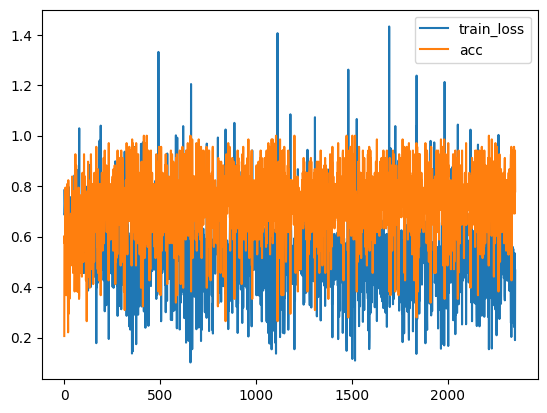

In [206]:
# Plot train_loss and acc
plt.plot(train_progression_df['epoch'], train_progression_df['train_loss'], label='train_loss')
plt.plot(train_progression_df['epoch'], train_progression_df['acc'], label='acc')
plt.legend()
plt.show()

# Sandbox

In [178]:
# Load test data from improv_data label_data.p, text_feature_data.p, price_feature_data.p

with open('improv_data/label_data.p', 'rb') as fp:
    true_label = pickle.load(fp)
with open('improv_data/text_feature_data.p', 'rb') as fp:
    text_ft_data = pickle.load(fp)
with open('improv_data/price_feature_data.p', 'rb') as fp:
    feature_data = pickle.load(fp)



{'0000000000': array([[[[-4.64586057e-02, -1.07767349e-02,  9.21173301e-03, ...,
            6.69815764e-02, -5.66859767e-02,  6.17853459e-03],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
         [[ 7.00906217e-02,  6.87085912e-02,  8.28827266e-03, ...,
            1.14809768e-02, -3.93873528e-02, -1.07900910e-02],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+